In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse import linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy

In [2]:
%matplotlib notebook

In [3]:
# Planck's constant is set to 1
m = 0.5 #the mass of the particle

T = 5 # final time
N = 50000 #number of time steps
dt = T/N #time step

xi = -20. #left endpont
xf = 20. #right endpoint
J = 5001 #number of space nodes
dx = (xf-xi)/(J-1) #space step

In [4]:
# setting up the potential
Xgrid = np.linspace(xi, xf, J)

def V(x):
    if x < 2 or x > 4:
        pot = 0
    else:
        pot = 8
    return pot

potential = np.zeros((J)) #now the potential as an array on the grid
for i in range(J):
    potential[i] = V(xi+i*dx)

In [5]:
Psi = np.zeros((N,J), complex) # this array will store the wave function

In [6]:
# we need to specify the intial Psi values
k0 = 3 #wave number
sigma0 = 1 #the standard deviation of the initial Gaussian
center = -5 #where the initial Gaussian is centered
Psi[0,:] = 1/(2*np.pi*sigma0**2)**(1/4)*np.exp((1j)*k0*Xgrid-(Xgrid-center)**2/(4*sigma0**2))

In [7]:
# setting up the ABC's
q = k0/m
h1 = 3*m*q
h2 = 3*(m**2)*(q**2)
h3 = (m**3)*(q**3)

ai = h2/(2*m) - V(xi)
af = h2/(2*m) - V(xf)
bi = h3/(2*m) - h1*V(xi)
bf = h3/(2*m) - h1*V(xf)

beta1 = -(1j)*ai/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) - bi/4
beta2 = (1j)*ai/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) - bi/4
beta3 = (1j)*ai/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) + bi/4
beta4 = -(1j)*ai/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) + bi/4

zeta1 = -(1j)*af/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) - bf/4
zeta2 = (1j)*af/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) - bf/4
zeta3 = (1j)*af/(2*dx) + 1/(dt*dx) - (1j)*h1/(2*dt) + bf/4
zeta4 = -(1j)*af/(2*dx) - 1/(dt*dx) - (1j)*h1/(2*dt) + bf/4

In [8]:
# setting up the tridiagonal matrices
ones = np.ones((J), complex)
alpha = (1j)*dt/(2*dx**2)
xis = np.zeros((J), complex)
for i in range(J):
    xis[i] = 2*m + (1j)*dt/(dx**2) + m*(1j)*dt*potential[i]
xis[0] = beta1
xis[J-1] = zeta1
up = -alpha*ones
down = -alpha*ones
up[1] = beta2
down[J-2] = zeta2
gamma = np.zeros((J), complex)
for i in range(J):
    gamma[i] = 2*m - (1j)*dt/(dx**2) - m*(1j)*dt*potential[i]
gamma[0] = beta3
gamma[J-1] = zeta3
ups = alpha*ones
downs = alpha*ones
ups[1] = beta4
downs[J-2] = zeta4

In [9]:
diags = np.array([-1, 0, 1])
vecs1 = np.array([down, xis, up])
vecs2 = np.array([downs, gamma, ups])

U1 = sp.spdiags(vecs1, diags, J, J)
U1 = U1.tocsc()
U2 = sp.spdiags(vecs2, diags, J, J)

In [10]:
LU = linalg.splu(U1)
for n in range(N-1):
    b = U2.dot(Psi[n,:])
    Psi[n+1,:] = LU.solve(b)

In [11]:
# Lets get the complex conjugate and the probability density
Psi_star = np.conj(Psi)
Density = Psi*Psi_star
Density = np.abs(Density) #Lets eliminate the zero imaginary parts

In [12]:
'''
fig, ax = plt.subplots()
line, = ax.plot(Xgrid, Density[0,:])

def animate(i):   
    line.set_ydata(Density[i,:])  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(Xgrid, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, N), init_func=init,
                              interval=1, blit=True)
plt.show()
'''

'\nfig, ax = plt.subplots()\nline, = ax.plot(Xgrid, Density[0,:])\n\ndef animate(i):   \n    line.set_ydata(Density[i,:])  # update the data\n    return line,\n\n# Init only required for blitting to give a clean slate.\ndef init():\n    line.set_ydata(np.ma.array(Xgrid, mask=True))\n    return line,\n\nani = animation.FuncAnimation(fig, animate, np.arange(0, N), init_func=init,\n                              interval=1, blit=True)\nplt.show()\n'

In [13]:
'''
plt.figure() #this figure shows the potential
plt.plot(Xgrid, potential, 'g')
plt.show()
'''

"\nplt.figure() #this figure shows the potential\nplt.plot(Xgrid, potential, 'g')\nplt.show()\n"

In [14]:
# we need a little subroutine to compute derivatives
# dim carries the dimension along which we will differentiate
def derivative(array, dim, dd):
    leng = array.shape[dim]
    der = np.zeros_like(array)
    for i in range(1, leng-1):
        indxl = [Ellipsis]*array.ndim
        indx = [Ellipsis]*array.ndim
        indxr = [Ellipsis]*array.ndim
        indxl[dim] = i-1
        indx[dim] = i
        indxr[dim] = i+1
        der[indx] = (array[indxr]-array[indxl])/(2*dd)
    indx0 = [Ellipsis]*array.ndim
    indx1 = [Ellipsis]*array.ndim
    indx0[dim] = 0
    indx1[dim] = 1
    der[indx0] = (array[indx1]-array[indx0])/dd
    indxm1 = [Ellipsis]*array.ndim
    indxm2 = [Ellipsis]*array.ndim
    indxm1[dim] = -1
    indxm2[dim] = -2
    der[indxm1] = (array[indxm1]-array[indxm2])/dd
    
    return der

In [15]:
'''
# let see if we can plot the quantum potential
R = Density**0.5

# the quantum potential has R in the denominator. We will replace all zeros there by ones
Rn = copy(R)
Rn[Rn < 0.001] = 1
'''

'\n# let see if we can plot the quantum potential\nR = Density**0.5\n\n# the quantum potential has R in the denominator. We will replace all zeros there by ones\nRn = copy(R)\nRn[Rn < 0.001] = 1\n'

In [16]:
'''
# the quantum potential
Q = - 1/(2*m)*derivative(derivative(R, 1, dx), 1, dx)/Rn
'''

'\n# the quantum potential\nQ = - 1/(2*m)*derivative(derivative(R, 1, dx), 1, dx)/Rn\n'

In [17]:
'''

figa, axa = plt.subplots()
plt.axis([xi, xf, -40, 20])
lina, = axa.plot(Xgrid, Q[0,:])

def animata(i):   
    lina.set_ydata(Q[i,:])  # update the data
    return lina,

# Init only required for blitting to give a clean slate.
def inita():
    lina.set_ydata(np.ma.array(Xgrid, mask=True))
    return lina,

ana = animation.FuncAnimation(figa, animata, np.arange(0, N), init_func=inita,
                              interval=1, blit=True)
plt.show()
'''

'\n\nfiga, axa = plt.subplots()\nplt.axis([xi, xf, -40, 20])\nlina, = axa.plot(Xgrid, Q[0,:])\n\ndef animata(i):   \n    lina.set_ydata(Q[i,:])  # update the data\n    return lina,\n\n# Init only required for blitting to give a clean slate.\ndef inita():\n    lina.set_ydata(np.ma.array(Xgrid, mask=True))\n    return lina,\n\nana = animation.FuncAnimation(figa, animata, np.arange(0, N), init_func=inita,\n                              interval=1, blit=True)\nplt.show()\n'

In [18]:
# Now lets compute the trajectories
S = np.angle(Psi)
for i in range(N):
    S[i,:] = np.unwrap(S[i,:])

In [19]:
'''
figb, axb = plt.subplots()
plt.axis([xi, xf, -100, 100])
lineb, = axb.plot(Xgrid, S[0,:])

def animateb(i):   
    lineb.set_ydata(S[i,:])  # update the data
    return line,

# Init only required for blitting to give a clean slate.
def init():
    lineb.set_ydata(np.ma.array(Xgrid, mask=True))
    return line,

ani = animation.FuncAnimation(figb, animateb, np.arange(0, N), init_func=init,
                              interval=10, blit=True)
plt.show()
'''

'\nfigb, axb = plt.subplots()\nplt.axis([xi, xf, -100, 100])\nlineb, = axb.plot(Xgrid, S[0,:])\n\ndef animateb(i):   \n    lineb.set_ydata(S[i,:])  # update the data\n    return line,\n\n# Init only required for blitting to give a clean slate.\ndef init():\n    lineb.set_ydata(np.ma.array(Xgrid, mask=True))\n    return line,\n\nani = animation.FuncAnimation(figb, animateb, np.arange(0, N), init_func=init,\n                              interval=10, blit=True)\nplt.show()\n'

In [20]:
v = np.zeros((N,J)) # this array contains the velocity field

In [21]:
v = derivative(S, 1, m*dx)

In [22]:
nt = 100 #this is how many trajectories will be shown
x = np.zeros((nt, N))
x[:,0] = np.linspace(center-3*sigma0, center+3*sigma0, nt)
# x[:,0] = np.random.normal(center, sigma0, nt)

In [23]:
for l in range(nt):
    # compute the current location of the particle on the grid
    for i in range(1,N):
        loca = (x[l,i-1]-xi)/dx #this is the location on the grid
        k = np.int(np.floor(loca))
        if k > J-2:
            x[l,i:N] = xf # The particle reaches the right end
            break
        elif k < 0:
            x[l,i:N] = xi # The left end
            break
        else:
            x[l,i] = x[l,i-1] + (v[i-1,k]*(loca-k)+v[i-1,k+1]*(1-loca+k))*dt

<IPython.core.display.Javascript object>


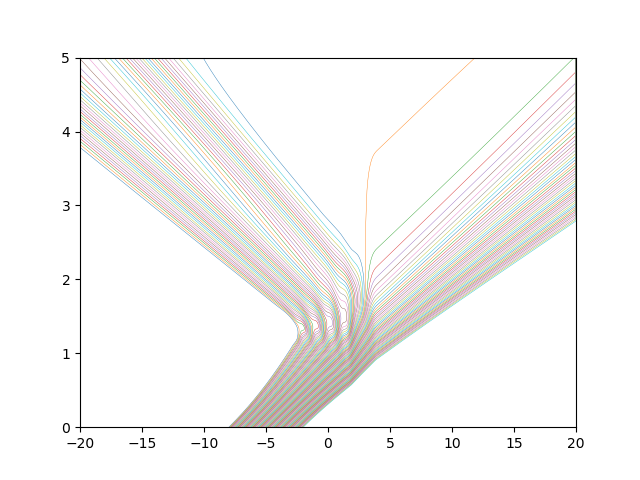

In [24]:
Tgrid = np.linspace(0, N*dt, N)

plt.figure()
plt.axis([xi, xf, 0, N*dt])
for l in range(nt):
    plt.plot(x[l,:],Tgrid, linewidth=0.3)
plt.show()

In [28]:
np.save('Saved/try0_pot', potential)
np.save('Saved/try0_psi', Psi)
np.save('Saved/try0_traj', x)